In [1]:
using Random
using Distributions: Gamma
using DataFrames, CSV
include("utils.jl")
include("statistics.jl")

_var (generic function with 2 methods)

In [2]:
# permutation test configuration
pooled = false
alpha = 0.05

oneSided = false
if oneSided
    alternativeType = "oneSided"
    alt_lo, alt_hi = "greater", "less"
    alpha /= 2
else
    alternativeType = alt_lo = alt_hi = "twoSided"
end

"twoSided"

In [3]:
mutable struct Args
    pooled::Bool
    alt_lo::String
    alt_hi::String
    px::AbstractMatrix
    py::AbstractMatrix
    batchSize::Int
    nx::Int
    ny::Int
end

In [3]:
# data dimensions
B  = 1      # num. coverage probabilities per boxplot
S  = 1800   # num. samples per coverage probability
nx = 6      # size of group 1
ny = 6      # size of group 2
px, py = partition(nx, ny)
dtype = Float32

Float32

In [17]:
# Generate data
Random.seed!(123)

shapeX = rand(1:10, B)
scaleX = rand(1:10, B)
distrX = Gamma.(shapeX, scaleX)

shapeY = rand(1000:10_000, B)
scaleY = rand(1000:10_000, B)
distrY = Gamma.(shapeY, scaleY)

deltas = @. dtype((shapeX * scaleX) - (shapeY * scaleY))

# produces B vectors of S * nx elements
# each vector is drawn from a distinct (but not necessarily distinct) distribution
x = rand.(distrX, S * nx)
y = rand.(distrY, S * ny)

# flatten into (B, S * n)
x = hcat(x...)'
y = hcat(y...)'

# reshape to 3D batch
x = dtype.(reshape(x, (B, S, nx)))
y = dtype.(reshape(y, (B, S, ny)))

# Compute t confidence intervals for each of the (B x S x nx) pairs
wide   = tconf(x, y, alpha=0.00001, pooled=pooled)
narrow = tconf(x, y, alpha=0.4, pooled=pooled)

wide   = reshape(wide, B, S)
narrow = reshape(narrow, B, S)

1×1800 Matrix{Tuple{Float32, Float32}}:
 (-2.4499f7, -2.42625f7)  …  (-2.4405f7, -2.42769f7)

In [5]:
function testStatDistr(x, y, pooled)
    combined = vcat(x, y)  # join original pair into single vector
    xs = combined[px]   # get all combinations of pairs from original pair
    ys = combined[py]
    return t(xs, ys, pooled)   # test statistic for all possible pairs of samples
end

function pval(x, y, pooled, alternative, delta)
    """
    Parameters
    ----------
    x : Vector{Real}
        Data for group 1
    
    y : Vector{Real}
        Data for group 2
    
    pooled : Bool
        Assume equal/unequal variances for the two groups
    
    alternative : String
        Type of alternative hypothesis
    
    delta : Real
        Null hypothesis difference in means
    
    Returns
    -------
    Float64
        Proportion of pairs among all sample combinations which have
        a test statistic as or more extreme than the original pair (x, y)
    """
    x_shift = x .- delta
    t_obs = t(x_shift, y, pooled)  # test statistic for observed data
    ts = testStatDistr(x_shift, y, pooled)

    if alternative == "less"
        n_extreme = count(ts .<= t_obs)
    elseif alternative == "greater"
        n_extreme = count(ts .>= t_obs)
    else
        n_extreme = count(@. (ts <= -abs(t_obs)) | (ts >= abs(t_obs)))
    end

    return dtype(n_extreme / size(px, 1))  # proportion of pairs w/ extreme test statistic
end

function search(x, y, start, stop;
                pooled=false, alternative="two_sided", isLowerBound=true,
                margin=0.005, threshold=1.0, alpha=0.05)
    p_start = pval(x, y, pooled, alternative, start)
    p_end   = pval(x, y, pooled, alternative, stop)
    #println("p_start = ", p_start, ", p_end = ", p_end)
    
    """
    if (p_start - alpha) * (p_end - alpha) > 0
        @show (p_start, p_end, alpha, x, y)
        @show alternative
    end
    """
    
    # p-values corresponding to `start` and `stop` must be on opposite sides of `alpha`
    @assert (p_start - alpha) * (p_end - alpha) <= 0

    p = p_new = delta = nothing
    percent_change = (old, new) -> 100 * abs(new-old) / old
    
    while true
        delta = (start + stop) / 2
        p_new = pval(x, y, pooled, alternative, delta)

        if !isnothing(p) && percent_change(p, p_new) <= threshold
            break  # (1) percent change in p-value is below `threshold`
        end
        
        compare = (alpha - p_new) - isLowerBound * 2 * (alpha - p_new)
        if margin < compare
            stop = delta
        elseif margin < -compare
            start = delta
        else
            break  # (2) p-value is within `margin` of `alpha`
        end

        p = p_new
    end
    
    return delta
end

function permInterval(x, y, wide, narrow, delta_true; pooled=false, alpha=0.05)
    """Returns true (false) if permutation test confidence interval does (not) include difference in
    population means.
    Parameters
    ----------
    x1 : Vector{Float64}
        Data for group 1
    x2 : Vector{Float64}
        Data for group 2
    partitions : Tuple{Matrix{Int64}, Matrix{Int64}}
        The i-th rows of x1[partitions[1]] and x2[partitions[2]] denote the i-th arrangement of
        the original (n1+n2) observations into two groups of size n1 and n2.
    delta_true : Float64
        Difference in population means
    pooled : Bool
        Assume pooled or unpooled variances
    alpha : Float64
        Significance level
    alternative : String
        Type of alternative hypothesis ("two-sided", "smaller", "larger")
    Returns
    -------
    Bool
        True (false) if permutation test confidence interval does (not) include difference in population means.
    """

    wide_lo, wide_hi = wide
    narrow_lo, narrow_hi = narrow

    # use binary search to find approximate permutation test confidence interval
    lo = search(x, y, wide_lo, narrow_lo,
                pooled=pooled, alpha=alpha, alternative=alt_lo, isLowerBound=true)
    hi = search(x, y, narrow_hi, wide_hi,
                pooled=pooled, alpha=alpha, alternative=alt_hi, isLowerBound=false)
    return lo, hi
    return [(lo <= delta_true <= hi), hi - lo]
end

function coverage(xs, ys, wide, narrow, delta_true; pooled=false, alpha=0.05)
    results = permInterval.(eachrow(xs), eachrow(ys), wide, narrow, delta_true,
                            pooled=pooled, alpha=alpha)
    results = hcat(results...)
    coverage = sum(results[1,:]) / S
    avg_CI_width = mean(results[2,:])
    return coverage, avg_CI_width
end

coverage (generic function with 1 method)

In [27]:
@time begin
results = coverage.(eachslice(x, dims=1),
                    eachslice(y, dims=1),
                    eachrow(wide),
                    eachrow(narrow),
                    deltas,
                    pooled=pooled,
                    alpha=alpha)
end

  1.346217 seconds (3.22 M allocations: 5.264 GiB, 17.41% gc time, 20.66% compilation time)


1-element Vector{Tuple{Float32, Float32}}:
 (0.9622222, 775673.0)

In [28]:
probs  = [x for (x, _) in results]
widths = [x for (_, x) in results]
df = DataFrame(prob=probs, width=widths, distrX=distrX, distrY=distrY)

,prob,width,distrX,distrY
,Float32,Float32,Gamma…,Gamma…
1,0.962222,775673.0,"Gamma{Float64}(α=6.0, θ=6.0)","Gamma{Float64}(α=9018.0, θ=2718.0)"


In [77]:
filename = alternativeType * "_" * (pooled ? "" : "un") * "pooled" * "_" * string(alpha) * ".csv"
CSV.write(filename, df)

"oneSided_unpooled_0.025.csv"

- overview/explain two-sample t-test
- derive t test confidence interval by inverting the t test of H0: delta = delta0 vs. H_A: delta != delta0, where delta = mu_1 - mu_2, delta0 in R
    - CI is the set of all deltas for which we do NOT reject the null == set of all deltas for which p-value > 0.05
    - set of all deltas for which the test statistic < t quantile == set of all deltas for which [mean(x1) - mean(x2) - delta] / s.d. (pooled or unpooled) < t quantile
    - output after solving for delta is the CI
- mention that the test statistic for difference in means (for pooled variances) follows a t distribution
    - DoF also changes for unpooled variances
- permutation test
    - explain how permTest p-value is derived (detail interval halving, etc.)
    - similar to above t test overview, start with two-sided alternative, then explain for inverting two one-sided tests (here, use alpha/2 instead of alpha)
    - literature review
- fix DoF in unpooled tconf()

---

delta = mean(x1) - mean(y1) = -65.77631441419432


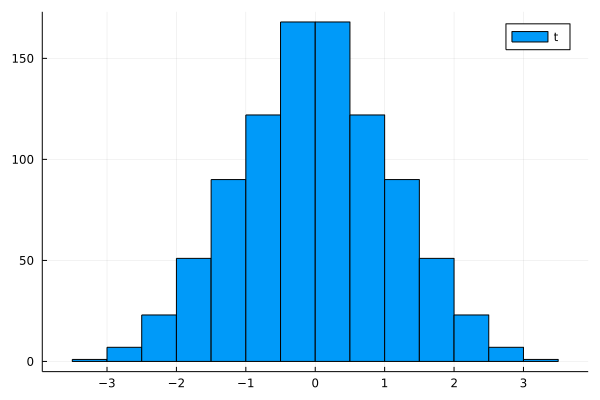

In [42]:
using StatsPlots

Random.seed!(123)
x1 = rand(Gamma(2, 3), nx)
y1 = rand(Gamma(7, 15), ny)
delta_true = (2*3) - (7*15)
@show delta = mean(x1) - mean(y1)
ts = testStatDistr(x1 .- delta, y1, pooled)
plt = histogram(ts, bins=20, label="t")
savefig(plt,"sampling_distribution.png")
plt

In [34]:
wide   = tconf(x1, y1, alpha=0.00001, pooled=pooled)
narrow = tconf(x1, y1, alpha=0.4, pooled=pooled)

# invert two one-sided tests
alt_lo, alt_hi = "greater", "less"
singleTwoSided = permInterval(x1, y1, wide[1], narrow[1], delta_true; pooled=pooled, alpha=0.025)
@show singleTwoSided

# invert single two-sided test
alt_lo = alt_hi = "two_sided"
twoOneSided = permInterval(x1, y1, wide[1], narrow[1], delta_true; pooled=pooled, alpha=0.05)
@show twoOneSided

singleTwoSided = (-78.990364f0, -53.703583f0)
twoOneSided = (-78.990364f0, -53.132923f0)


(-78.990364f0, -53.132923f0)

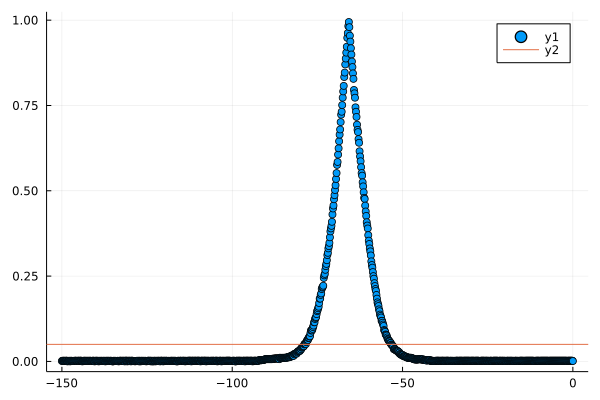

In [41]:
deltas = LinRange(-150, 0, 1000)
p = [pval(x1, y1, pooled, "two_sided", delta) for delta in deltas]
plt = scatter(deltas, p)
hline!([0.05])
savefig(plt,"delta_p_twoSided.png")
plt

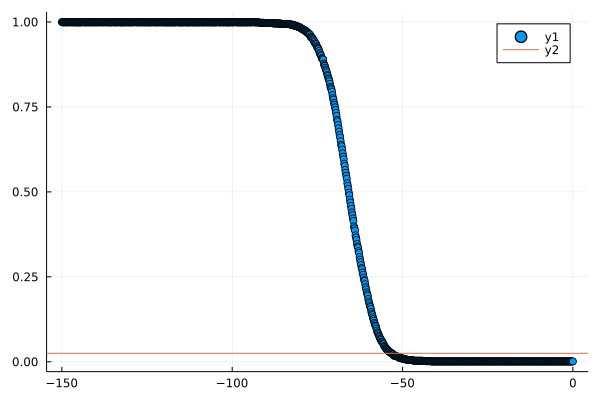

In [39]:
deltas = LinRange(-150, 0, 1000)
p = [pval(x1, y1, pooled, "less", delta) for delta in deltas]
plt = scatter(deltas, p)
hline!([0.025])
savefig(plt,"delta_p_less.png")
plt

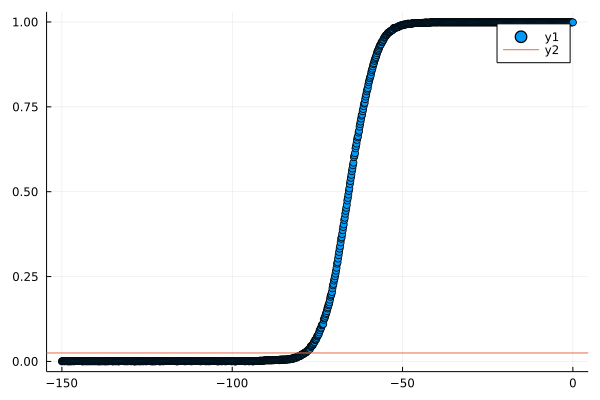

In [40]:
deltas = LinRange(-150, 0, 1000)
p = [pval(x1, y1, pooled, "greater", delta) for delta in deltas]
plt = scatter(deltas, p)
hline!([0.025])
savefig(plt,"delta_p_greater.png")
plt